# IMO zadanie 4 - Rozszerzenia lokalnego przeszukiwania

Emilia Maciejewska <br>
Anita Zielińska

In [65]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime
import statistics

## 0. Wczytywanie danych

In [66]:
problemA = tsplib95.load("kroA200.tsp")
problemA = problemA.as_keyword_dict()

In [67]:
problemB = tsplib95.load("kroB200.tsp")
problemB = problemB.as_keyword_dict()

In [68]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [69]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)

## 1. Algorytm startowy

In [70]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [71]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

In [72]:
def greedy_start(experimentId, p1, p2):
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
        
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]
    
    notSelected = []
    for j in range (matrix_length):
        if j != p1 and j != p2:
            notSelected.append(j)

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        
        random.shuffle(notSelected)
        pr = math.ceil(len(notSelected)*0.1)
        
        for i in range(pr):
            if notSelected[i] not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(notSelected[i])
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = notSelected[i]
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        notSelected.remove(newItem)
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    resultVal[0] += d_matrix[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += d_matrix[result[1][len(result[1]) - 1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 2. Lokalne przeszukiwanie w wersji stromej (wierzchołki + krawędzie)

### 2.1 Sąsiedztwo międzytrasowe wierzchołki

In [73]:
def neighborExternalV (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
            dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
            dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
            dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
            d = dis2 - dis1
            if d < delta:
                delta = d
                r = [aA[i], aB[j]]
    return delta, r

### 2.2 Sąsiedztwo wewnątrztrasowe krawędzie

In [74]:
def neighborInternalESingle (mat, aA, delta, r):
    for i in range(1, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0 and d < delta:
                    delta = d
                    r = [aA[i], aA[j]]
    return delta, r

In [75]:
def neighborInternalE (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    delta1, r1 = neighborInternalESingle(mat, aA, delta, r)
    delta2, r2 = neighborInternalESingle(mat, aB, delta, r)
    if delta1 < delta2:
        return delta1, r1, "0"
    else:
        return delta2, r2, "1"

### 2.3 Lokalne przeszukiwanie

In [76]:
def steepestE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result)
        delta2, r2, cycleId = neighborInternalE(experimentId, result)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            tempA = []
            cycleId = int(cycleId)
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]

        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

## 3. Multiple start local search (MSLS)

**Lokalne przeszukiwanie z róznych losowych punktów startowych**

In [77]:
def msls(experimentId, p1, p2):
    start, startVal = greedy_start(experimentId, p1, p2)
    r, v = steepestE(experimentId, start, startVal)
    bestResult = np.copy(r)
    bestVal = np.copy(v)
    bestStart = np.copy(start)
    bestStartV = np.copy(startVal)
    for i in range(99):
        start, startVal = greedy_start(experimentId, p1, p2)
        r, v = steepestE(experimentId, start, startVal)
        if v[0]+v[1]<bestVal[0]+bestVal[1]:
            bestResult = np.copy(r)
            bestVal = np.copy(v)
            bestStart = np.copy(start)
            bestStartV = np.copy(startVal)    
    return bestResult, bestVal[0]+bestVal[1], bestStart, bestStartV[0]+bestStartV[1]

## 4. Iterated local search (ILS1)

**Iteracyjne przeszukiwanie lokalne z niewielką perturbacją**

In [78]:
def perturbacja(experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = np.copy(result[0][:-1])
    aB = np.copy(result[1][:-1])
    aAc = np.copy(aA)
    pA = np.arange(0, len(aA))
    pB = np.arange(0, len(aB))
    np.random.shuffle(pA)
    np.random.shuffle(pB)

    for z in range(4):
        aA[pA[z]] = aB[pB[z]]
        aB[pB[z]] = aAc[pA[z]]
    aA = np.append(aA, aA[0])
    aB = np.append(aB, aB[0])
    newResult = [aA, aB]
    #print(newResult)
    
    newVal = [0,0]
    for i in range(len(newResult)):
        for j in range(1, len(newResult[i])):
            newVal[i] += mat[newResult[i][j-1]][newResult[i][j]]
        
    return newResult, newVal 

In [130]:
def perturbacjaKrawedzie(experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = np.copy(result[0][:-1])
    aB = np.copy(result[1][:-1])
    pA = np.arange(0, len(aA))
    pB = np.arange(0, len(aB))
    np.random.shuffle(pA)
    np.random.shuffle(pB)

    for z in range(0,6,2):
        if pA[z] + 1!= pA[z+1] and pA[z] - 1!= pA[z+1]:
            index1 = pA[z]
            index2 = pA[z+1]
            if pA[z] > pA[z+1]:
                index1 = pA[z+1]
                index2 = pA[z]
            tempA = np.copy(aA)
            tempA = tempA[index1+1: index2]
            tempA = np.flip(tempA)
            j = index1+1
            for i in range (len(tempA)):
                aA[j] = tempA[i]
                j +=1
        if pB[z] + 1!= pB[z+1] and pB[z] - 1!= pB[z+1]:
            index1 = pB[z]
            index2 = pB[z+1]
            if pB[z] > pB[z+1]:
                index1 = pB[z+1]
                index2 = pB[z]
            tempB = np.copy(aB)
            tempB = tempB[index1+1: index2]
            tempB = np.flip(tempB)
            j = index1+1
            for i in range (len(tempB)):
                aB[j] = tempB[i]
                j +=1
            
    aA = np.append(aA, aA[0])
    aB = np.append(aB, aB[0])
    newResult = [aA, aB]
    #print(newResult)
    
    newVal = [0,0]
    for i in range(len(newResult)):
        for j in range(1, len(newResult[i])):
            newVal[i] += mat[newResult[i][j-1]][newResult[i][j]]
        
    return newResult, newVal 

            

In [131]:
def ils1(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    start, startVal = greedy_start(experimentId, p1, p2)
    bestR, bestV = steepestE(experimentId, start, startVal)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pR, pV = perturbacjaKrawedzie(experimentId, bestR)
        newR, newV = steepestE(experimentId, pR, pV)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t   

## 5. Iterated local search (ILS2)

**Iteracyjne przeszukiwanie lokalne z Large-scale neighborhood search**

In [80]:
def destroy(result):
    aA = np.copy(result[0][:-1])
    aB = np.copy(result[1][:-1])
    pA = np.arange(0, len(aA))
    pB = np.arange(0, len(aB))
    np.random.shuffle(pA)
    np.random.shuffle(pB)
    partA = pA[0:20]
    partB = pB[0:20]
    np.sort(partA) 
    np.sort(partB)
    new_aA = np.delete(aA, partA)
    new_aB = np.delete(aB, partB)
    
    return [new_aA, new_aB]


In [81]:
def repair(experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat)

    selected = dict()
    for i in range(len(result)):
        for j in range(len(result[i])):
            selected[result[i][j]] = 1
    resultVal = [[0],[0]]
    
    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new = np.append(new, i)
                    new = np.concatenate((new, result[cycleId][j:]))
                    dist = 0
                    for k in range(1, len(new)):
                        dist += mat[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    resultVal[0] += mat[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += mat[result[1][len(result[1]) - 1]][result[1][0]]
    result[0] = np.append(result[0], result[0][0])
    result[1] = np.append(result[1], result[1][0])
    return result, resultVal

In [82]:
def ils2a(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    start, startVal = greedy_start(experimentId, p1, p2)
    bestR, bestV = steepestE(experimentId, start, startVal)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pD = destroy(bestR)
        pRr, pRv = repair(experimentId, pD)
        newR, newV = steepestE(experimentId, pRr, pRv)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t  

In [83]:
def ils2b(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    bestR, bestV = greedy_start(experimentId, p1, p2)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pD = destroy(bestR)
        newR, newV = repair(experimentId, pD)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t 

In [108]:
def ils2c(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    start, startVal = greedy_start(experimentId, p1, p2)
    bestR, bestV = steepestE(experimentId, start, startVal)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pD = destroy(bestR)
        newR, newV = repair(experimentId, pD)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t 

## 6. Przygotowanie wyników

In [84]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [85]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [86]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [87]:
def summarizeStart(result, resultVal, title, dataArr):
    valueArray = np.array(resultVal)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

In [88]:
def summarize(result, resultVal, timeT, title, dataArr):
    valueArray = np.array(resultVal)
    timeArray = np.array(timeT)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print(index)
    print(valueArray)
    print("czas obliczeń")
    print("min", np.min(timeArray))
    print("max", np.max(timeArray))
    print("mean", np.mean(timeArray))
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

## 7. Eksperyment A

In [89]:
resultS = []
resultSV = []

result1 = []
resultVal1 = []
time1 = []

result2 = []
resultVal2 = []
time2 = []
startingPoints = dict()

In [90]:
def runExperiment(experimentId):
    itersNumber = 10
    
    for i in range(itersNumber):
        p1, p2 = selectP(experimentId)
        print("nr iteracji", i)
    
        #msls
        start_time = datetime.datetime.now()
        r,v,sR,sV = msls(experimentId, p1, p2)
        end_time = datetime.datetime.now()
        result1.append(r)
        resultVal1.append(v)
        resultS.append(sR)
        resultSV.append(sV)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        time1.append(execution_time)
        
        #steepest (jako punkt odniesienia) 
        start_time = datetime.datetime.now()
        start, startVal = greedy_start(experimentId, p1, p2)
        r,v = steepestE(experimentId, start, startVal)
        v_sum = v[0]+v[1]
        end_time = datetime.datetime.now()
        result2.append(r)
        resultVal2.append(v_sum)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        time2.append(execution_time)

In [91]:
runExperiment('A')

nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9


wyniki algorytmu
min 39164
max 44581
mean 41390.9


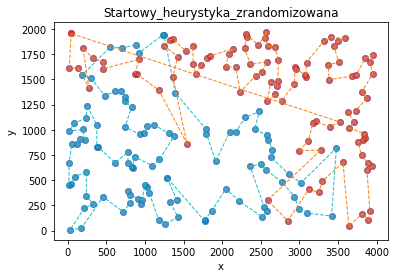

wyniki algorytmu
min 32907
max 34691
mean 33526.5
0
[32907 32956 34568 33038 33435 34691 33712 33225 33152 33581]
czas obliczeń
min 389314.099
max 504016.685
mean 439635.17870000005


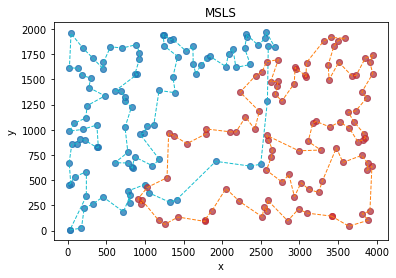

wyniki algorytmu
min 34068
max 38599
mean 36688.0
0
[34068 36522 37869 36158 37888 37594 38599 35780 36501 35901]
czas obliczeń
min 3140.661
max 6180.707
mean 4502.0592


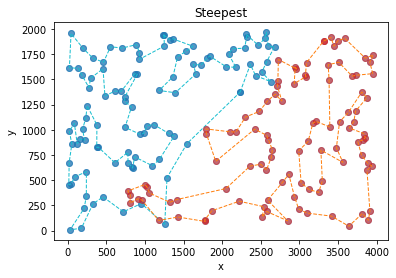

In [92]:
summarizeStart(resultS, resultSV, "Startowy_heurystyka_zrandomizowana", dataArrA)
summarize(result1, resultVal1, time1, "MSLS", dataArrA)
summarize(result2, resultVal2, time2, "Steepest", dataArrA)

In [134]:
def runILS(experimentId):
    m_t = statistics.mean(time1)
    print(time1)
    print(m_t)
    itersNumber = 5    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils1
        p1, p2 = selectP(experimentId)
        r,v,t = ils1(experimentId, p1, p2, m_t)
        print(v)
        result3.append(r)
        resultVal3.append(v)
        time3.append(t) 

[371155.881, 391960.396, 374735.126, 350121.178, 392073.865, 366727.081, 350491.99, 351565.323, 362971.10199999996, 370943.961]
368274.5903
nr iteracji 0
33833
nr iteracji 1
33367
nr iteracji 2
36399
nr iteracji 3
32676
nr iteracji 4
32479
wyniki algorytmu
min 32479
max 36399
mean 33750.8
4
[33833 33367 36399 32676 32479]
czas obliczeń
min 368458.846
max 369117.57
mean 368759.8408


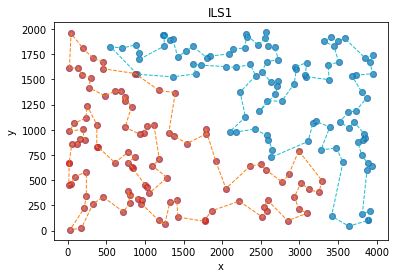

In [135]:
result3 = []
resultVal3 = []
time3 = []
startingPoints = dict()

runILS('A')
summarize(result3, resultVal3, time3, "ILS1", dataArrA)

In [97]:
def runILS2a(experimentId):
    m_t = statistics.mean(time1)
    print(time1)
    print(m_t)
    itersNumber = 10    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils2
        p1, p2 = selectP(experimentId)
        r,v,t = ils2a(experimentId, p1, p2, m_t)
        result4.append(r)
        resultVal4.append(v)
        time4.append(t) 

[409671.69, 400352.525, 504016.685, 434362.302, 457380.799, 452769.815, 407052.535, 445232.992, 389314.099, 496198.34500000003]
439635.1787
nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9
wyniki algorytmu
min 31232
max 33685
mean 32548.2
5
[32791 31700 31693 31429 33134 31232 33685 33662 33203 32953]
czas obliczeń
min 439720.17
max 442482.624
mean 441217.69850000006


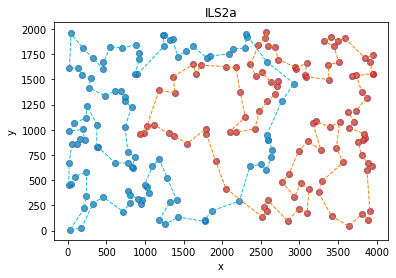

In [98]:
result4 = []
resultVal4 = []
time4 = []
startingPoints = dict()

runILS2a('A')
summarize(result4, resultVal4, time4, "ILS2a", dataArrA)

In [99]:
def runILS2b(experimentId):
    m_t = statistics.mean(time1)
    print(time1)
    print(m_t)
    itersNumber = 10    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils2
        p1, p2 = selectP(experimentId)
        r,v,t = ils2b(experimentId, p1, p2, m_t)
        result5.append(r)
        resultVal5.append(v)
        time5.append(t) 

[409671.69, 400352.525, 504016.685, 434362.302, 457380.799, 452769.815, 407052.535, 445232.992, 389314.099, 496198.34500000003]
439635.1787
nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9
wyniki algorytmu
min 31561
max 37921
mean 35497.6
0
[31561 34201 37492 37921 35665 34692 35870 36814 36428 34332]
czas obliczeń
min 440079.72599999997
max 442790.467
mean 441225.66260000004


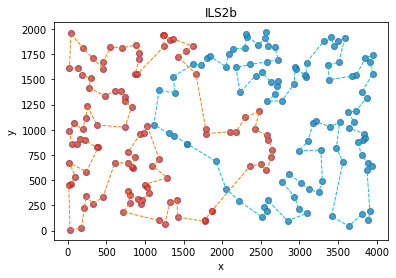

In [100]:
result5 = []
resultVal5 = []
time5 = []
startingPoints = dict()

runILS2b('A')
summarize(result5, resultVal5, time5, "ILS2b", dataArrA)

In [116]:
def runILS2c(experimentId):
    m_t = statistics.mean(time1)
    m_t = m_t
    print(time1)
    print(m_t)
    itersNumber = 10    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils2
        p1, p2 = selectP(experimentId)
        r,v,t = ils2c(experimentId, p1, p2, m_t)
        result6.append(r)
        resultVal6.append(v)
        time6.append(t) 

wyniki algorytmu
min 31051
max 33984
mean 32363.6
2
[31616 33354 31051 33984 33235 33164 31181 31333 33058 31660]
czas obliczeń
min 368346.55199999997
max 371908.885
mean 370136.8699


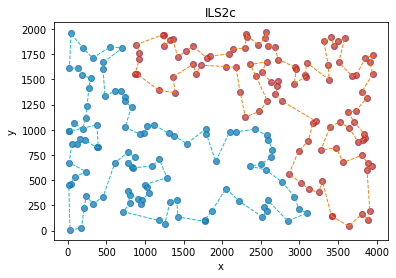

In [111]:
result6 = []
resultVal6 = []
time6 = []
startingPoints = dict()

runILS2c('A')
summarize(result6, resultVal6, time6, "ILS2c", dataArrA)

## 8. Eksperyment B

In [101]:
resultS = []
resultSV = []

result1 = []
resultVal1 = []
time1 = []

result2 = []
resultVal2 = []
time2 = []
startingPoints = dict()

In [102]:
runExperiment('B')

nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9


wyniki algorytmu
min 35987
max 44279
mean 40269.5


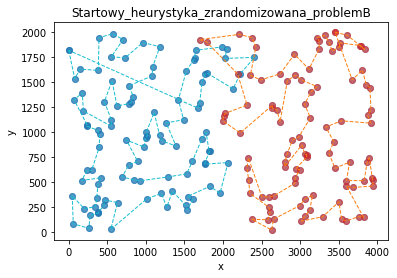

wyniki algorytmu
min 32083
max 35016
mean 33335.7
7
[34232 35016 33528 32809 33889 33572 32560 32083 32329 33339]
czas obliczeń
min 350121.178
max 392073.865
mean 368274.5903


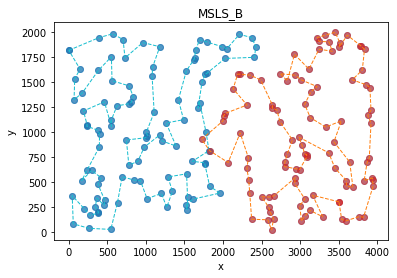

wyniki algorytmu
min 33674
max 38428
mean 36744.1
7
[37864 38376 36245 34656 36959 37996 36970 33674 36273 38428]
czas obliczeń
min 3098.016
max 4776.834
mean 3668.9865


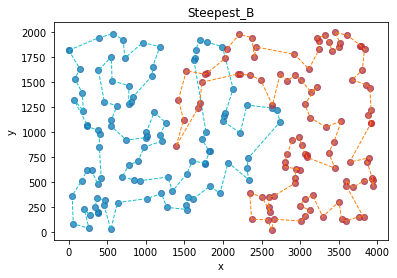

In [104]:
summarizeStart(resultS, resultSV, "Startowy_heurystyka_zrandomizowana_problemB", dataArrB)
summarize(result1, resultVal1, time1, "MSLS_B", dataArrB)
summarize(result2, resultVal2, time2, "Steepest_B", dataArrB)

[371155.881, 391960.396, 374735.126, 350121.178, 392073.865, 366727.081, 350491.99, 351565.323, 362971.10199999996, 370943.961]
368274.5903
nr iteracji 0
34087
nr iteracji 1
35453
nr iteracji 2
33928
nr iteracji 3
33774
nr iteracji 4
33488
wyniki algorytmu
min 33488
max 35453
mean 34146.0
4
[34087 35453 33928 33774 33488]
czas obliczeń
min 368363.238
max 368667.96
mean 368494.7536


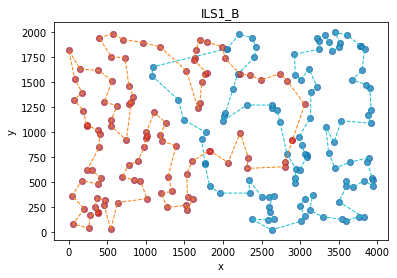

In [136]:
result3 = []
resultVal3 = []
time3 = []
startingPoints = dict()

runILS('B')
summarize(result3, resultVal3, time3, "ILS1_B", dataArrB)

[371155.881, 391960.396, 374735.126, 350121.178, 392073.865, 366727.081, 350491.99, 351565.323, 362971.10199999996, 370943.961]
368274.5903
nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9
wyniki algorytmu
min 31179
max 33689
mean 32687.6
7
[33302 31580 32519 33015 33267 33202 33573 31179 31550 33689]
czas obliczeń
min 368911.693
max 371684.711
mean 370115.02


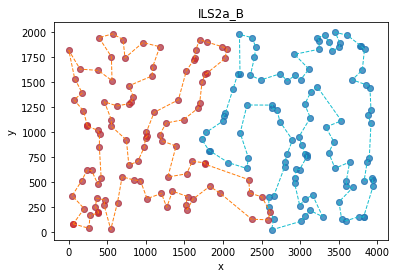

In [106]:
result4 = []
resultVal4 = []
time4 = []
startingPoints = dict()

runILS2a('B')
summarize(result4, resultVal4, time4, "ILS2a_B", dataArrB)

[371155.881, 391960.396, 374735.126, 350121.178, 392073.865, 366727.081, 350491.99, 351565.323, 362971.10199999996, 370943.961]
368274.5903
nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9
wyniki algorytmu
min 34629
max 38661
mean 36610.4
0
[34629 35103 37129 38661 38602 38246 36668 35595 36156 35315]
czas obliczeń
min 368406.607
max 371550.63899999997
mean 369888.89739999996


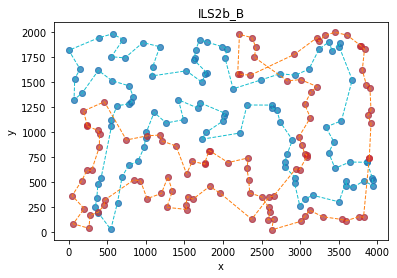

In [107]:
result5 = []
resultVal5 = []
time5 = []
startingPoints = dict()

runILS2b('B')
summarize(result5, resultVal5, time5, "ILS2b_B", dataArrB)

[371155.881, 391960.396, 374735.126, 350121.178, 392073.865, 366727.081, 350491.99, 351565.323, 362971.10199999996, 370943.961]
368274.5903
nr iteracji 0
nr iteracji 1
nr iteracji 2
nr iteracji 3
nr iteracji 4
nr iteracji 5
nr iteracji 6
nr iteracji 7
nr iteracji 8
nr iteracji 9
wyniki algorytmu
min 32474
max 35268
mean 34179.7
1
[33530 32474 34078 34477 33880 34612 34833 35268 33708 34937]
czas obliczeń
min 369103.242
max 373710.74399999995
mean 371658.9266


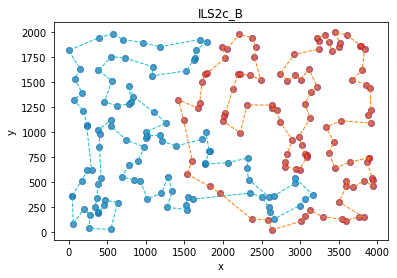

In [117]:
result6 = []
resultVal6 = []
time6 = []
startingPoints = dict()

runILS2c('B')
summarize(result6, resultVal6, time6, "ILS2c_B", dataArrB)